<div >
<img src = "../banner.jpg" />
</div>

# Missclasification Rates

In [32]:
#Cargar librerías 
require("pacman")
p_load(tidyverse)
set.seed(1011)

In [33]:
#Leer los datos 
credit <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/credit_class.rds?raw=true"))
head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,0,6,1169,4,67,terrible,goods/repair,foreign,FALSE
2,1,48,5951,2,22,poor,goods/repair,foreign,FALSE
3,0,12,2096,2,49,terrible,edu,foreign,FALSE
4,0,42,7882,2,45,poor,goods/repair,foreign,FALSE
5,1,24,4870,3,53,poor,newcar,foreign,FALSE
6,0,36,9055,2,35,poor,edu,foreign,FALSE


In [34]:
table(credit$foreign)


   <NA> foreign  german 
      0     963      37 

In [35]:
default<-credit$Default  #defino ahora va a servir después

#mutación de factores
credit<-credit %>% mutate(Default=factor(Default,levels=c(0,1),labels=c("No","Si")),
                          history=factor(history,levels=c("good","poor","terrible"),labels=c("buena","mala","terrible")),
                          foreign=factor(foreign,levels=c("foreign","german"),labels=c("extranjero","aleman")),
                          purpose=factor(purpose,levels=c("newcar","usedcar","goods/repair","edu", "biz" ),labels=c("auto_nuevo","auto_usado","bienes","educacion","negocios")))         

In [36]:
head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,No,6,1169,4,67,terrible,bienes,extranjero,FALSE
2,Si,48,5951,2,22,mala,bienes,extranjero,FALSE
3,No,12,2096,2,49,terrible,educacion,extranjero,FALSE
4,No,42,7882,2,45,mala,bienes,extranjero,FALSE
5,Si,24,4870,3,53,mala,auto_nuevo,extranjero,FALSE
6,No,36,9055,2,35,mala,educacion,extranjero,FALSE


In [37]:
table(credit$foreign)


extranjero     aleman 
       963         37 

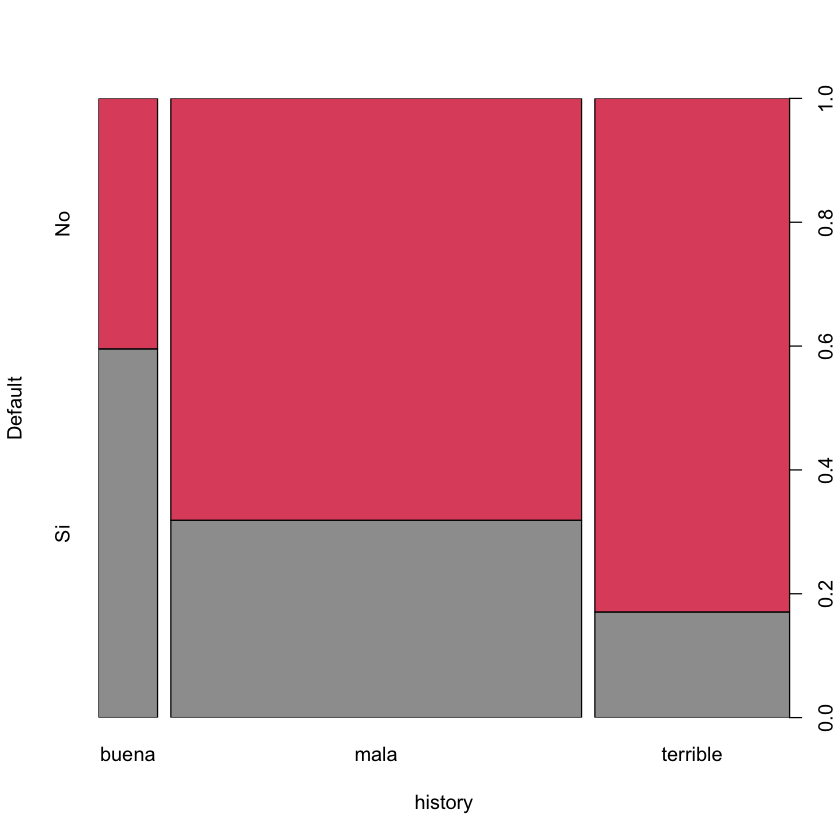

In [38]:
## plot a mosaic
plot(Default ~ history, data=credit, col=c(8,2), ylab="Default") ## surprise!
## the dangers of choice-based sampling!  

In [39]:
mylogit <- glm(Default~., data = credit, family = "binomial")
summary(mylogit,type="text")


Call:
glm(formula = Default ~ ., family = "binomial", data = credit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3303  -0.7993  -0.5631   0.9694   2.5703  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.936e-01  4.579e-01  -0.423  0.67239    
duration           2.666e-02  8.152e-03   3.270  0.00108 ** 
amount             9.793e-05  3.670e-05   2.668  0.00763 ** 
installment        2.361e-01  7.687e-02   3.072  0.00213 ** 
age               -1.598e-02  7.348e-03  -2.175  0.02964 *  
historymala       -1.101e+00  2.490e-01  -4.424 9.67e-06 ***
historyterrible   -1.849e+00  2.837e-01  -6.518 7.13e-11 ***
purposeauto_usado -1.702e+00  3.273e-01  -5.201 1.98e-07 ***
purposebienes     -7.551e-01  1.867e-01  -4.044 5.25e-05 ***
purposeeducacion  -1.473e-01  3.263e-01  -0.451  0.65166    
purposenegocios   -8.501e-01  2.801e-01  -3.036  0.00240 ** 
foreignaleman     -1.322e+00  5.814e-01  -2.274  0.02298 *  
rentTRUE

In [40]:
pred<-predict(mylogit,newdata = credit, type = "response")
summary(pred)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01743 0.15698 0.25703 0.30000 0.41753 0.93381 

In [41]:
## what are our misclassification rates?
rule <- 1/2 # Bayes Rule

sum( (pred>rule)[default==0] )/sum(default==0) #False positive rate

[1] 0.08714286

In [42]:
sum( (pred>rule)[default==1] )/sum(default==1) #True positive rate

[1] 0.3

In [43]:
## what are our misclassification rates?
rule <- 1/5 
sum( (pred>rule)[default==0] )/sum(default==0) #False positive rate

[1] 0.5385714

In [44]:
sum( (pred>rule)[default==1] )/sum(default==1) #True positive rate

[1] 0.87

In [45]:
## plot the ROC curve for classification of y with p
roc <- function(p,y, ...){
  y <- factor(y)
  n <- length(p)
  p <- as.vector(p)
  Q <- p > matrix(rep(seq(0,1,length=100),n),ncol=100,byrow=TRUE)
  specificity <- colMeans(!Q[y==levels(y)[1],])
  sensitivity <- colMeans(Q[y==levels(y)[2],])
  plot(1-specificity, sensitivity, type="l", ...)
  abline(a=0,b=1,lty=2,col=8)
}
#remplazaria Specificiad y Sensitividad por FPR y TPR

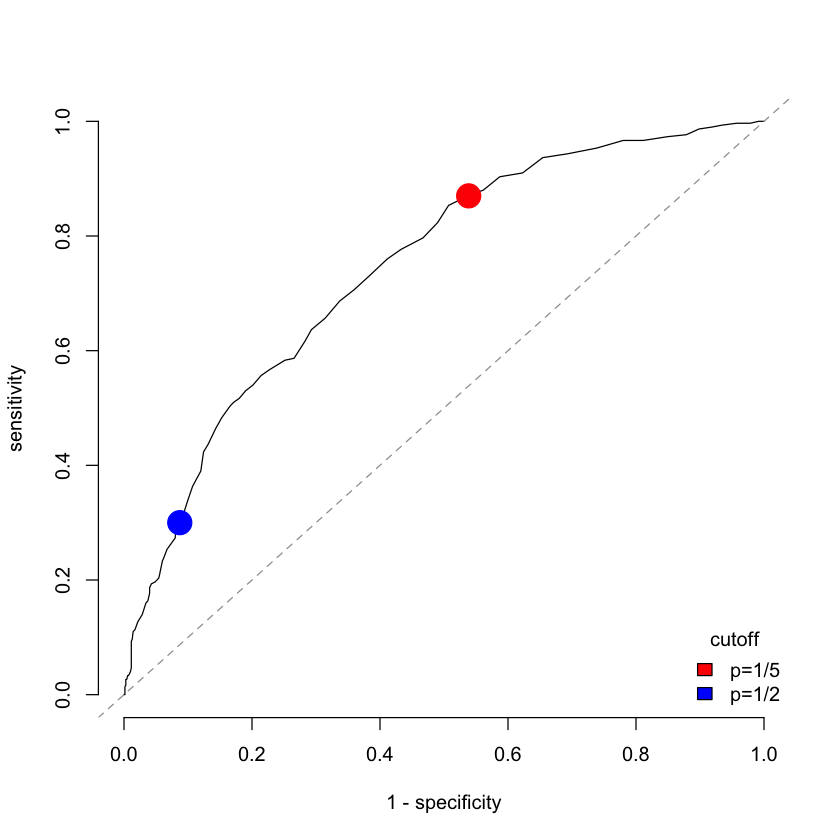

In [46]:

roc(p=pred, y=default, bty="n")
## our 1/5 rule cutoff
points(x= 1-mean((pred<.2)[default==0]), 
       y=mean((pred>.2)[default==1]), 
       cex=4, pch=20, col='red') 
## a standard `max prob' (p=.5) rule
points(x= 1-mean((pred<.5)[default==0]), 
       y=mean((pred>.5)[default==1]), 
       cex=4, pch=20, col='blue') 
legend("bottomright",fill=c("red","blue"),
       legend=c("p=1/5","p=1/2"),bty="n",title="cutoff")


## Aside: Dummy Vars

In [47]:
p_load("caret")
dmy <- dummyVars(" ~ .", data = credit) # One-hot-encoding
head(dmy)

$call
dummyVars.default(formula = " ~ .", data = credit)

$form
~.
<environment: 0x7fcdebc293a0>

$vars
[1] "Default"     "duration"    "amount"      "installment" "age"        
[6] "history"     "purpose"     "foreign"     "rent"       

$facVars
[1] "Default" "history" "purpose" "foreign" "rent"   

$lvls
$lvls$Default
[1] "No" "Si"

$lvls$history
[1] "buena"    "mala"     "terrible"

$lvls$purpose
[1] "auto_nuevo" "auto_usado" "bienes"     "educacion"  "negocios"  

$lvls$foreign
[1] "extranjero" "aleman"    

$lvls$rent
[1] NA      "FALSE" "TRUE" 


$sep
[1] "."


In [48]:
credit <- data.frame(predict(dmy, newdata = credit))

In [49]:
head(credit)

,Default.No,Default.Si,duration,amount,installment,age,history.buena,history.mala,history.terrible,purpose.auto_nuevo,purpose.auto_usado,purpose.bienes,purpose.educacion,purpose.negocios,foreign.extranjero,foreign.aleman,rent.NA,rent.FALSE,rent.TRUE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,6,1169,4,67,0,0,1,0,0,1,0,0,1,0,0,1,0
2,0,1,48,5951,2,22,0,1,0,0,0,1,0,0,1,0,0,1,0
3,1,0,12,2096,2,49,0,0,1,0,0,0,1,0,1,0,0,1,0
4,1,0,42,7882,2,45,0,1,0,0,0,1,0,0,1,0,0,1,0
5,0,1,24,4870,3,53,0,1,0,1,0,0,0,0,1,0,0,1,0
6,1,0,36,9055,2,35,0,1,0,0,0,0,1,0,1,0,0,1,0


## Out of sample prediction

In [50]:
credit<- credit  %>% mutate(Default=factor(Default.Si,levels=c(0,1),labels=c("No","Si")))

In [51]:
inTrain <- createDataPartition(
  y = credit$Default.Si,## La variable dependiente u objetivo 
  p = .7, ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- credit[ inTrain,]
test  <- credit[-inTrain,]

In [52]:
head(train)

,Default.No,Default.Si,duration,amount,installment,age,history.buena,history.mala,history.terrible,purpose.auto_nuevo,purpose.auto_usado,purpose.bienes,purpose.educacion,purpose.negocios,foreign.extranjero,foreign.aleman,rent.NA,rent.FALSE,rent.TRUE,Default
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,0,1,48,5951,2,22,0,1,0,0,0,1,0,0,1,0,0,1,0,Si
3,1,0,12,2096,2,49,0,0,1,0,0,0,1,0,1,0,0,1,0,No
5,0,1,24,4870,3,53,0,1,0,1,0,0,0,0,1,0,0,1,0,Si
6,1,0,36,9055,2,35,0,1,0,0,0,0,1,0,1,0,0,1,0,No
9,1,0,12,3059,2,61,0,1,0,0,0,1,0,0,1,0,0,1,0,No
11,0,1,12,1295,3,25,0,1,0,1,0,0,0,0,1,0,0,0,1,Si


### Logit

In [26]:
fiveStats <- function(...) c(twoClassSummary(...), defaultSummary(...)) 



ctrl<- trainControl(method = "cv",
                    number = 5,
                    summaryFunction = fiveStats, 
                    classProbs = TRUE,
                    verbose=FALSE,
                    savePredictions = T)

set.seed(1410)
mylogit_caret <- train(Default.Si~duration+amount+installment+age+
                       history.buena+history.mala+history.terrible+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+purpose.negocios+
                       foreign.extranjero+foreign.aleman+
                       rent.NA+rent.FALSE+rent.TRUE, 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial", 
                       metric = 'ROC')




mylogit_caret


Warning message in train.default(x, y, weights = w, ...):
“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”
Warning message in train.default(x, y, weights = w, ...):
“cannnot compute class probabilities for regression”


ERROR: Error in evalSummaryFunction(y, wts = weights, ctrl = trControl, lev = classLevels, : train()'s use of ROC codes requires class probabilities. See the classProbs option of trainControl()


In [53]:
set.seed(1410)
mylogit_caret <- train(Default~duration+amount+installment+age+
                       history.buena+history.mala+history.terrible+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+purpose.negocios+
                       foreign.extranjero+foreign.aleman+
                       rent.NA+rent.FALSE+rent.TRUE, 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial", 
                       metric = 'ROC')




mylogit_caret


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misl

Generalized Linear Model 

700 samples
 17 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 561, 559, 560, 560 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa  
  0.7078935  0.9169482  0.2010796  0.7185148  0.14365


In [55]:
set.seed(1410)
mylogit_caret <- train(Default~duration+amount+installment+age+
                       history.buena+history.mala+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+
                       foreign.extranjero+
                       +rent.TRUE, 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial", 
                       metric = 'ROC')


mylogit_caret

Generalized Linear Model 

700 samples
 12 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 561, 559, 560, 560 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa  
  0.7078935  0.9169482  0.2010796  0.7185148  0.14365


In [56]:
predictTest_logit <- data.frame(
  obs = test$Default,                                    ## observed class labels
  predict(mylogit_caret, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(mylogit_caret, newdata = test, type = "raw")    ## predicted class labels
)


In [57]:
head(predictTest_logit)

,obs,No,Si,pred
,<fct>,<dbl>,<dbl>,<fct>
1,No,0.9495503,0.05044975,No
4,No,0.6613619,0.33863813,No
7,No,0.8174441,0.18255586,No
8,No,0.7748455,0.22515449,No
10,Si,0.6093878,0.39061224,No
14,Si,0.8519662,0.14803376,No


In [58]:
twoClassSummary(data = predictTest_logit, lev = levels(predictTest_logit$obs))

ROC      Sens      Spec 
0.7340984 0.9278351 0.2924528

In [59]:
prSummary(data = predictTest_logit, lev = levels(predictTest_logit$obs))

AUC Precision    Recall         F 
0.8180105 0.7058824 0.9278351 0.8017817

### LDA


\begin{align}
p (Y=1|X)=\frac{f(X|Y=1)p(Y=1)}{m(X)}
\end{align}


with $m(X)$ is the marginal distribution of $X$, i.e.

\begin{align}
m(X)=\int f(X|Y=y)p(Y=y)dy
\end{align}

Recall that there are two states of nature $y \rightarrow i\in\{0,1\}$


\begin{align}
m(X) &= f(X|Y=1)p(Y=1) + f(X|Y=0)p(Y=0) 
\end{align}


\begin{align}
m(X)     &= f(X|Y=1)p(Y=1) + f(X|Y=0)(1-p(Y=1))
\end{align}

We need to estimate $f(X|Y=1)$,  $f(X|Y=0)$ and $p(Y=1)$ 


#### By Hand


- Let's start by estimating $p(Y=1)$. We've done this before

    \begin{align}
    p(Y=1) = \frac{\sum_{i=1}^n 1[Y_i=1]}{N}
    \end{align}


In [60]:
p1<-sum(train$Default.Si)/dim(train)[1]
p1

[1] 0.2771429


- Next $f(X|Y=j)$ with $j=0,1$. 

    - If we assume one predictor and $X|Y\sim N(\mu_j,\sigma_j)$, the problem boils down to estimating $\mu_j,\sigma_j$

    - LDA makes it simpler, assumes $\sigma_j=\sigma$ $\forall j$

To do this partition the sample in two $Y=0$ and $Y=1$, estimate the moments and get $\hat{f}(X|Y=j)$

**Means**

\begin{align}
\hat{\mu}_k=\frac{1}{n_k}\sum_{i:y_i=k}x_i
\end{align}

In [61]:
#Means
mu1<-mean(train$duration[train$Default.Si==1])
mu1

[1] 23.92784

In [62]:
mu0<-mean(train$duration[train$Default.Si==0])
mu0

[1] 19.63834

**Variance**

\begin{align}
\hat{\sigma}^2 = \frac{1}{N-K} \sum_{k=1}^K \sum_{i:y_i=k} (x_i -\hat{\mu}_k)^2
\end{align}

In [63]:
#Variance
g1<-sum((train$duration[train$Default.Si==1]-mu1)^2)
g0<-sum((train$duration[train$Default.Si==0]-mu0)^2)


sigma<-sqrt((g1+g0)/(dim(train)[1]-2))
sigma

[1] 11.72902

With the moments, now we can obtain $f(X|Y=j)$ with $j=0,1$. 

In [64]:
f1<-dnorm(test$duration,mean=mu1,sd=sigma)
f0<-dnorm(test$duration,mean=mu0,sd=sigma)

- Finally plug everything into the Bayes Rule and we are done:
\begin{align}
p (Y=1|X)=\frac{f(X|Y=1)p(Y=1)}{f(X|Y=1)p(Y=1) + f(X|Y=0)(1-p(Y=1))}
\end{align}


In [65]:
post_hand<-f1*p1/(f1*p1+f0*(1-p1))
head(post_hand)

[1] 0.1898781 0.4186529 0.2912018 0.3739312 0.3312645 0.2912018

In [66]:
p_load("MASS")     # LDA
lda_simple <- lda(Default.Si~duration, data = train)
lda_simple_pred<-predict(lda_simple,test)
names(lda_simple_pred)


[1] "class"     "posterior" "x"

In [67]:
posteriors<-data.frame(lda_simple_pred$posterior)
posteriors$hand<-post_hand

head(posteriors)

,X0,X1,hand
,<dbl>,<dbl>,<dbl>
1,0.8101219,0.1898781,0.1898781
4,0.5813471,0.4186529,0.4186529
7,0.7087982,0.2912018,0.2912018
8,0.6260688,0.3739312,0.3739312
10,0.6687355,0.3312645,0.3312645
14,0.7087982,0.2912018,0.2912018


#### Caret

In [68]:
lda_fit = train(Default~duration+amount+installment+age, 
                data=train, 
                method="lda",
                trControl = ctrl,
                metric = 'ROC')

lda_fit

Linear Discriminant Analysis 

700 samples
  4 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 560, 560, 560, 560 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa     
  0.6140498  0.9802368  0.0462888  0.7214286  0.03650808


In [69]:
predictTest_lda <- data.frame(
  obs = test$Default,                                    ## observed class labels
  predict(lda_fit, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(lda_fit, newdata = test, type = "raw")    ## predicted class labels
)



In [70]:
head(predictTest_lda)

,obs,No,Si,pred
,<fct>,<dbl>,<dbl>,<fct>
1,No,0.8796759,0.1203241,No
4,No,0.6579534,0.3420466,No
7,No,0.7984374,0.2015626,No
8,No,0.6465574,0.3534426,No
10,Si,0.5813129,0.4186871,No
14,Si,0.8151111,0.1848889,No


In [71]:
twoClassSummary(data = predictTest_lda, lev = levels(predictTest_lda$obs))


ROC       Sens       Spec 
0.67462556 0.99484536 0.08490566

In [72]:
prSummary(data = predictTest_lda, lev = levels(predictTest_lda$obs))

AUC Precision    Recall         F 
0.7580579 0.6655172 0.9948454 0.7975207

 ### ROC performance

#### In-sample

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Observations: 700

Number of groups: 1

Observations per group: 700

Positive: Si

Negative: No

Group: Group 1

Positive: 194

Negative: 506

***Performance Metrics***

Group 1 Optimal Informedness = 0.173709302799397

Group 1 AUC-ROC = 0.61



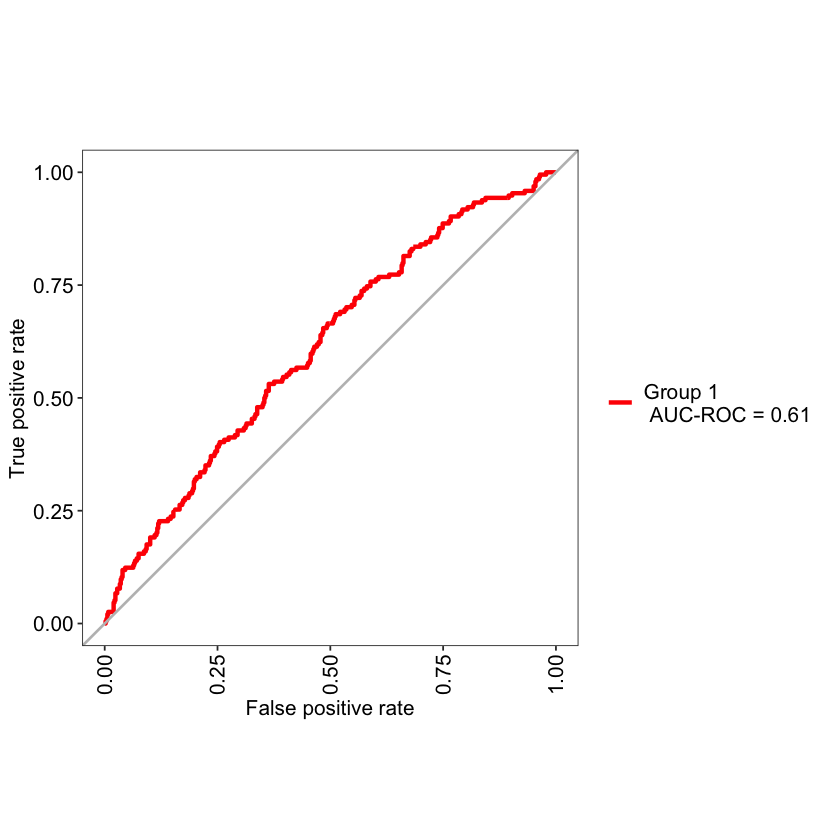

In [73]:
p_load("MLeval")

res_lda_fit <- evalm(lda_fit,plots="r")

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Group 2 type: cv

Observations: 1400

Number of groups: 2

Observations per group: 700

Positive: Si

Negative: No

Group: LDA

Positive: 194

Negative: 506

Group: Logit

Positive: 194

Negative: 506

***Performance Metrics***

LDA Optimal Informedness = 0.173709302799397

Logit Optimal Informedness = 0.328144737378265

LDA AUC-ROC = 0.61

Logit AUC-ROC = 0.7



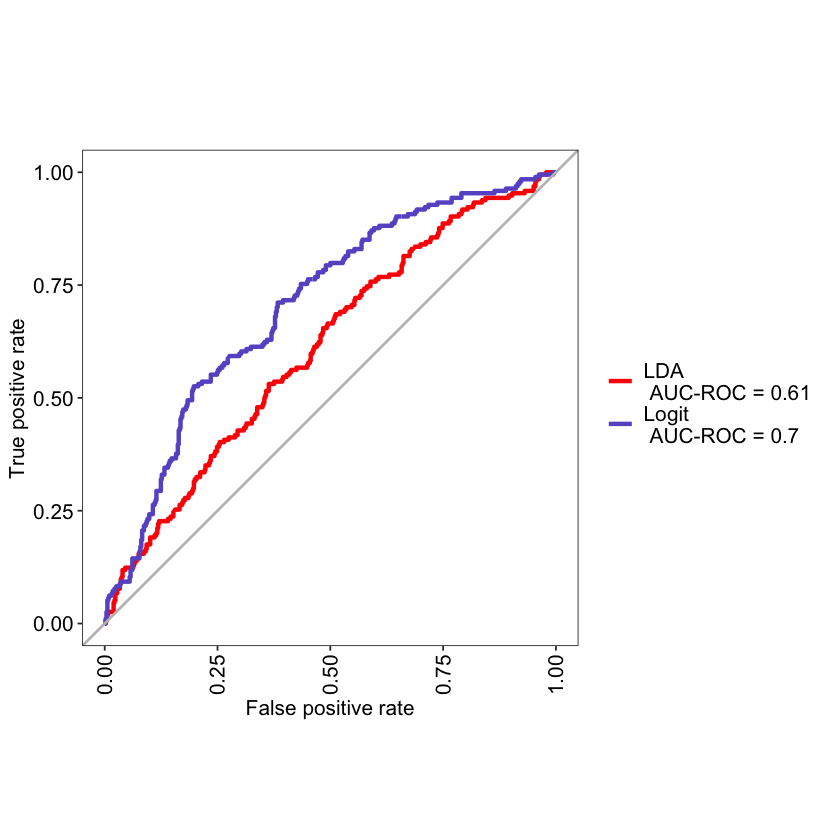

In [78]:
res_insample_all <- evalm(list(lda_fit,mylogit_caret),gnames=c('LDA','Logit'),plots='r')

#### Out-of-sample

***MLeval: Machine Learning Model Evaluation***

Input: data frame of probabilities of observed labels

Group does not exist, making column.

Observations: 300

Number of groups: 1

Observations per group: 300

Positive: No

Negative: obs

Group: Group1

Positive: 194

Negative: 0

Warning message in evalm(predictTest_logit, plots = "r"):
“NAs introduced by coercion”
***Performance Metrics***

Group1 Optimal Informedness = 0.363158918498347

Group1 AUC-ROC = 0.73



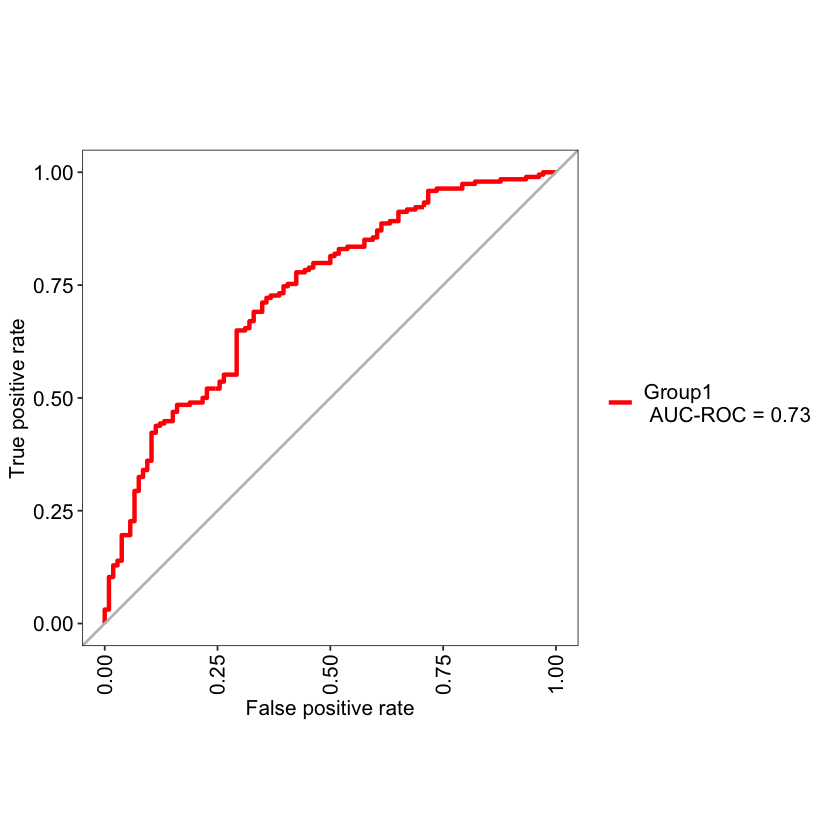

In [75]:
res_outsample_logit <- evalm(predictTest_logit,plots='r')

***MLeval: Machine Learning Model Evaluation***

Input: data frame of probabilities of observed labels

Group does not exist, making column.

Observations: 300

Number of groups: 1

Observations per group: 300

Positive: No

Negative: obs

Group: Group1

Positive: 194

Negative: 0

Warning message in evalm(predictTest_lda, plots = "r"):
“NAs introduced by coercion”
***Performance Metrics***

Group1 Optimal Informedness = 0.275821824547753

Group1 AUC-ROC = 0.67



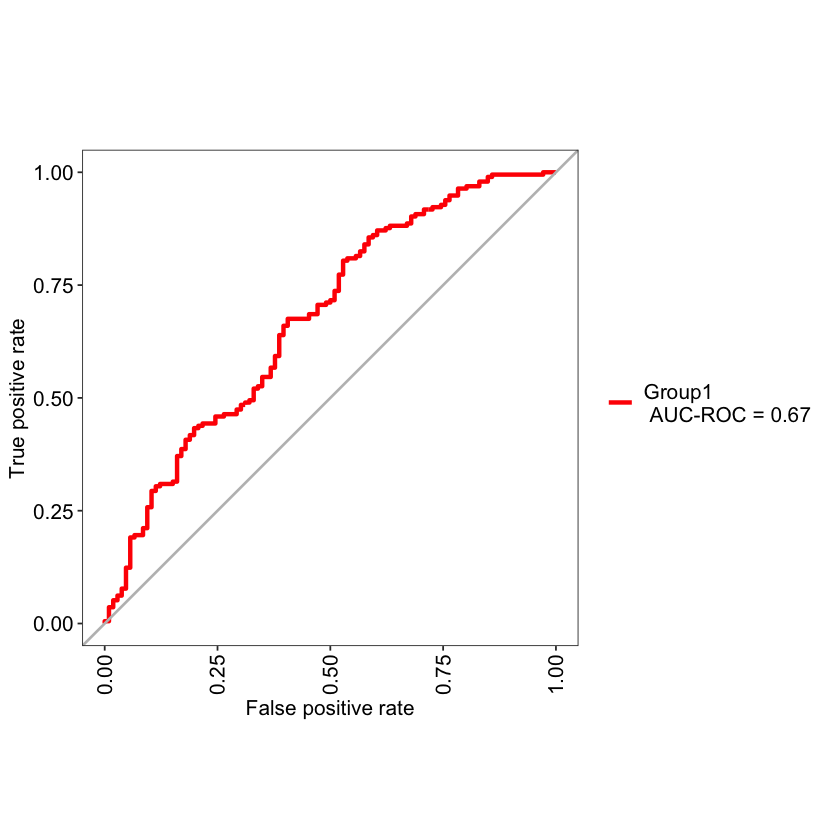

In [76]:
res_outsample_lda <- evalm(predictTest_lda,plots='r')